<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Heston Model">Heston Model</a></li>
        <a href="#Step 1: Data Generation with the Heston Model">Step 1: Data Generation with the Heston Model</a>
        <br><a href="#Step 2: Heston Option Pricing ANN">Step 2: Heston Option Pricing ANN</a>
        <br><a href="#Step 3: Heston Implicit Volatility ANN">Step 3: Heston Implicit Volatility ANN</a>
    </ol>
</div>
<br>
<hr>

<h1>Tools</h1>

In [ ]:
%%capture
!pip install pyDOE tensorflow_addons
import pickle
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy import integrate
from pyDOE import lhs
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, save_model, load_model
from google.colab import drive


<div id="Step 1: Data Generation with the Heston Model">
    <h1>Step 1: Data Generation with the Heston Model</h1>
</div>

<center>

| ANN Parameters            | Range              | Method |
|---------------------------|--------------------|--------|
| Input                     |                    |        |
| Moneyness, m = S0/K       | (0.6, 1.4)         | LHS    |
| Time to maturity, τ       | (0.1, 1.4)(year)   | LHS    |
| Risk free rate, r         | (0.0%, 10%)        | LHS    |
| Correlation, ρ            | (−0.95, 0.0)       | LHS    |
| Reversion speed, κ        | (0.0, 2.0)         | LHS    |
| Long average variance, $\theta$ | (0.0, 0.5)         | LHS    |
| Volatility of volatility, $\sigma$ | (0.0, 0.5)       | LHS    |
| Initial variance, ν0      | (0.05, 0.5)        | LHS    |
| Output                    |                    |        |
| European call price, V    | (0, 0.67)          |        |

</center>

The $LHS$ method, also known as Latin Hypercube Sampling, is a statistical sampling technique used in various fields, including engineering, computer experiments, and simulation studies. It is designed to create a representative sample of parameter values from a multivariate distribution.
<br>In Latin Hypercube Sampling, the parameter space is divided into equal intervals along each dimension, and then one random sample is selected from each interval. This ensures that the resulting sample covers the entire parameter space uniformly and efficiently. The Latin Hypercube structure helps to reduce sampling variability and ensures a more representative sample compared to simple random sampling.![image.png](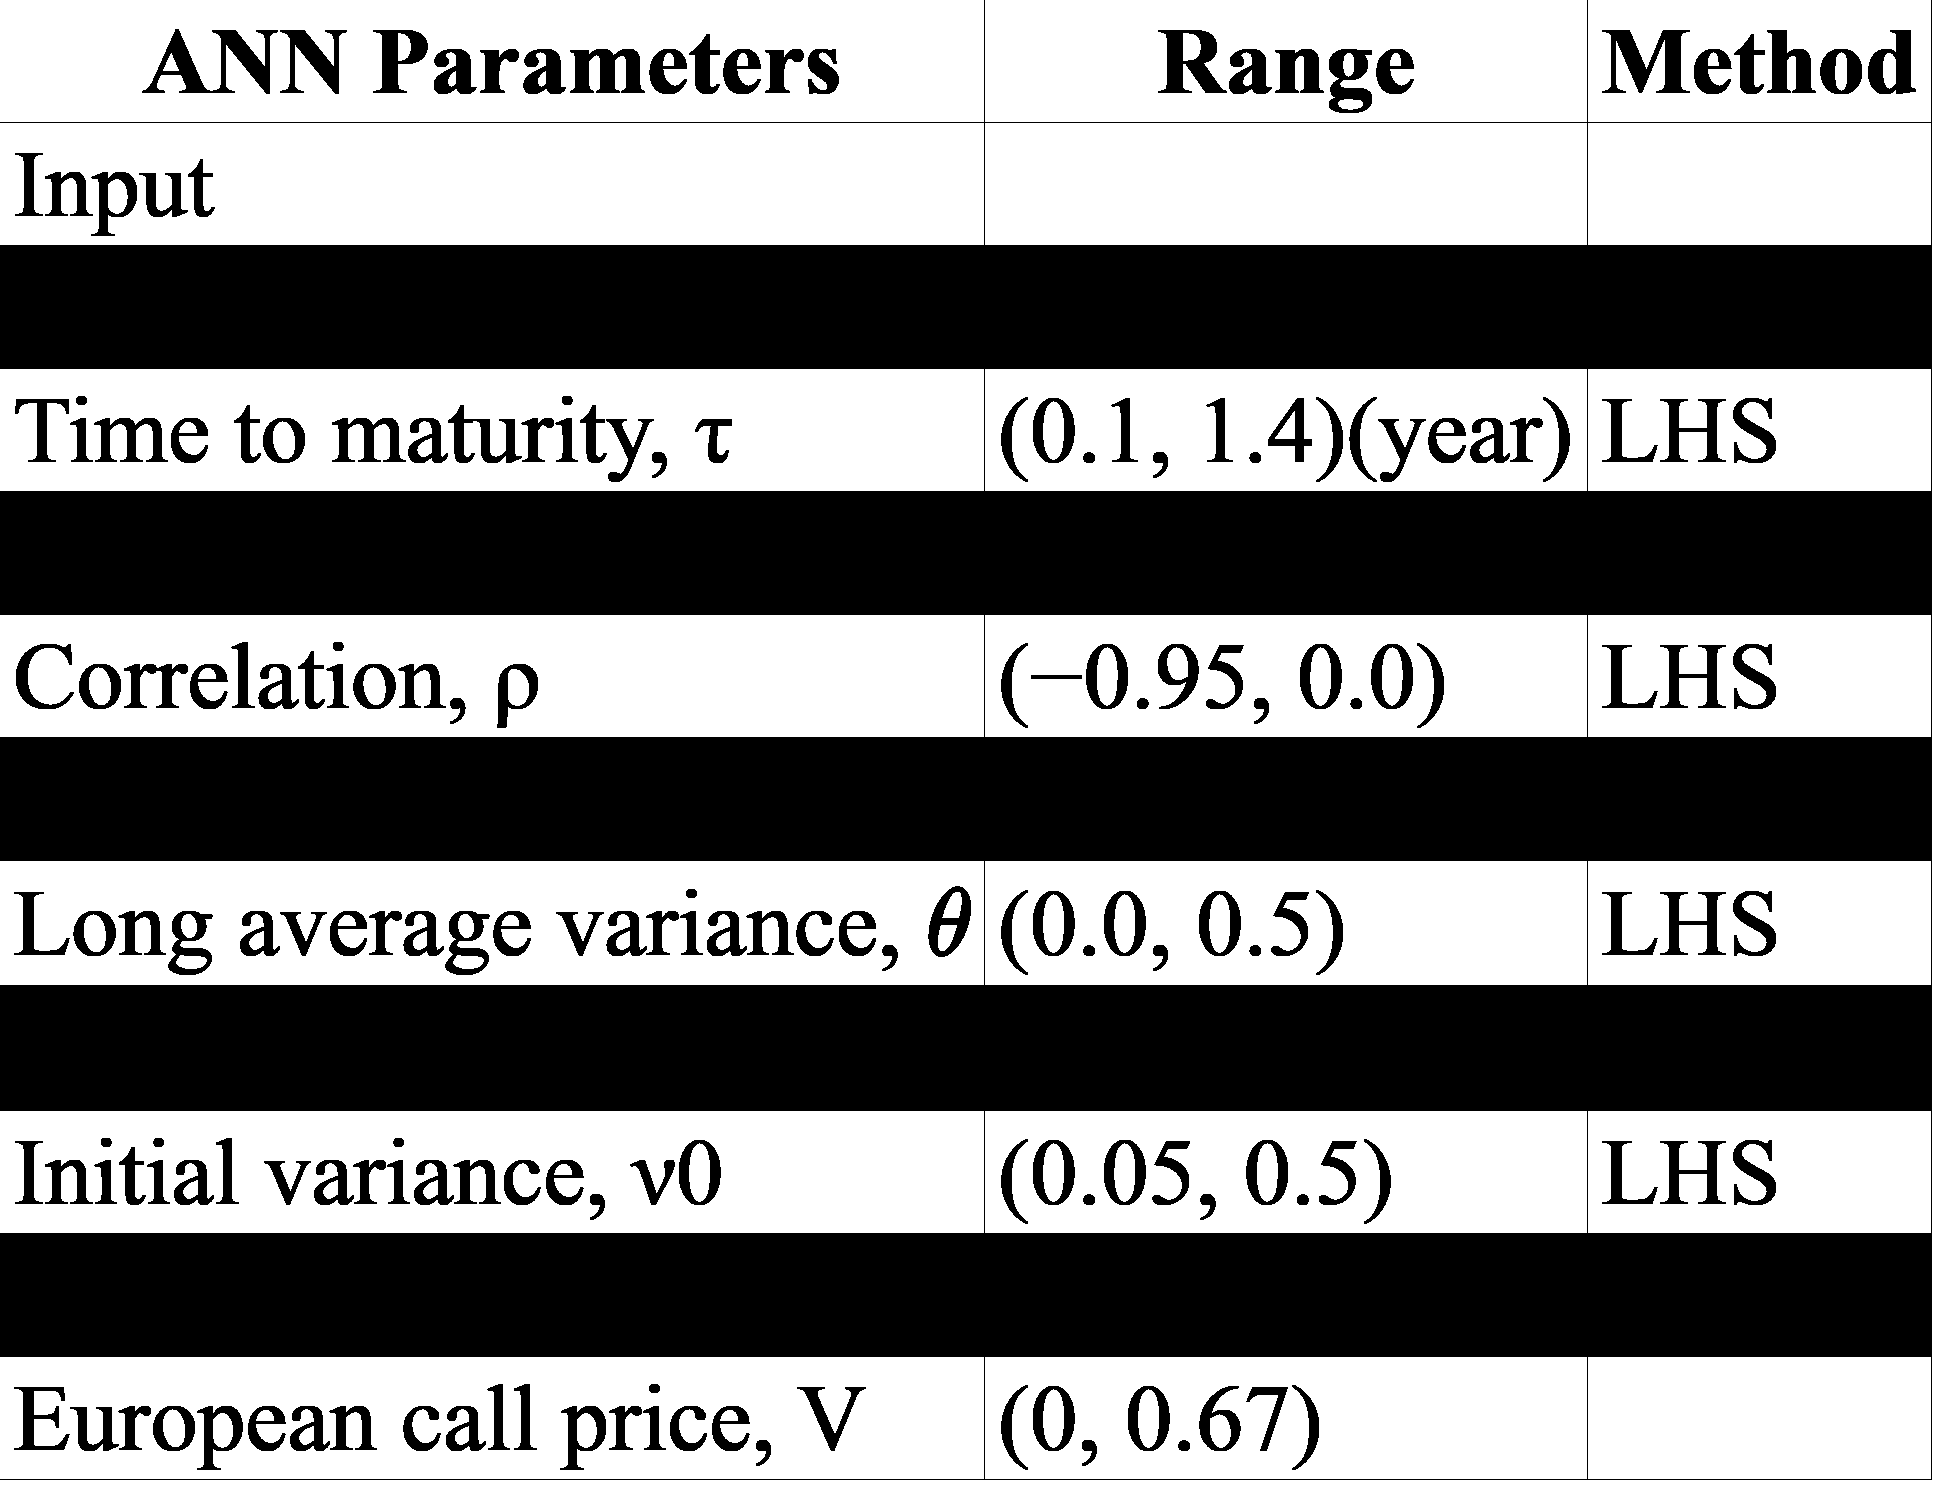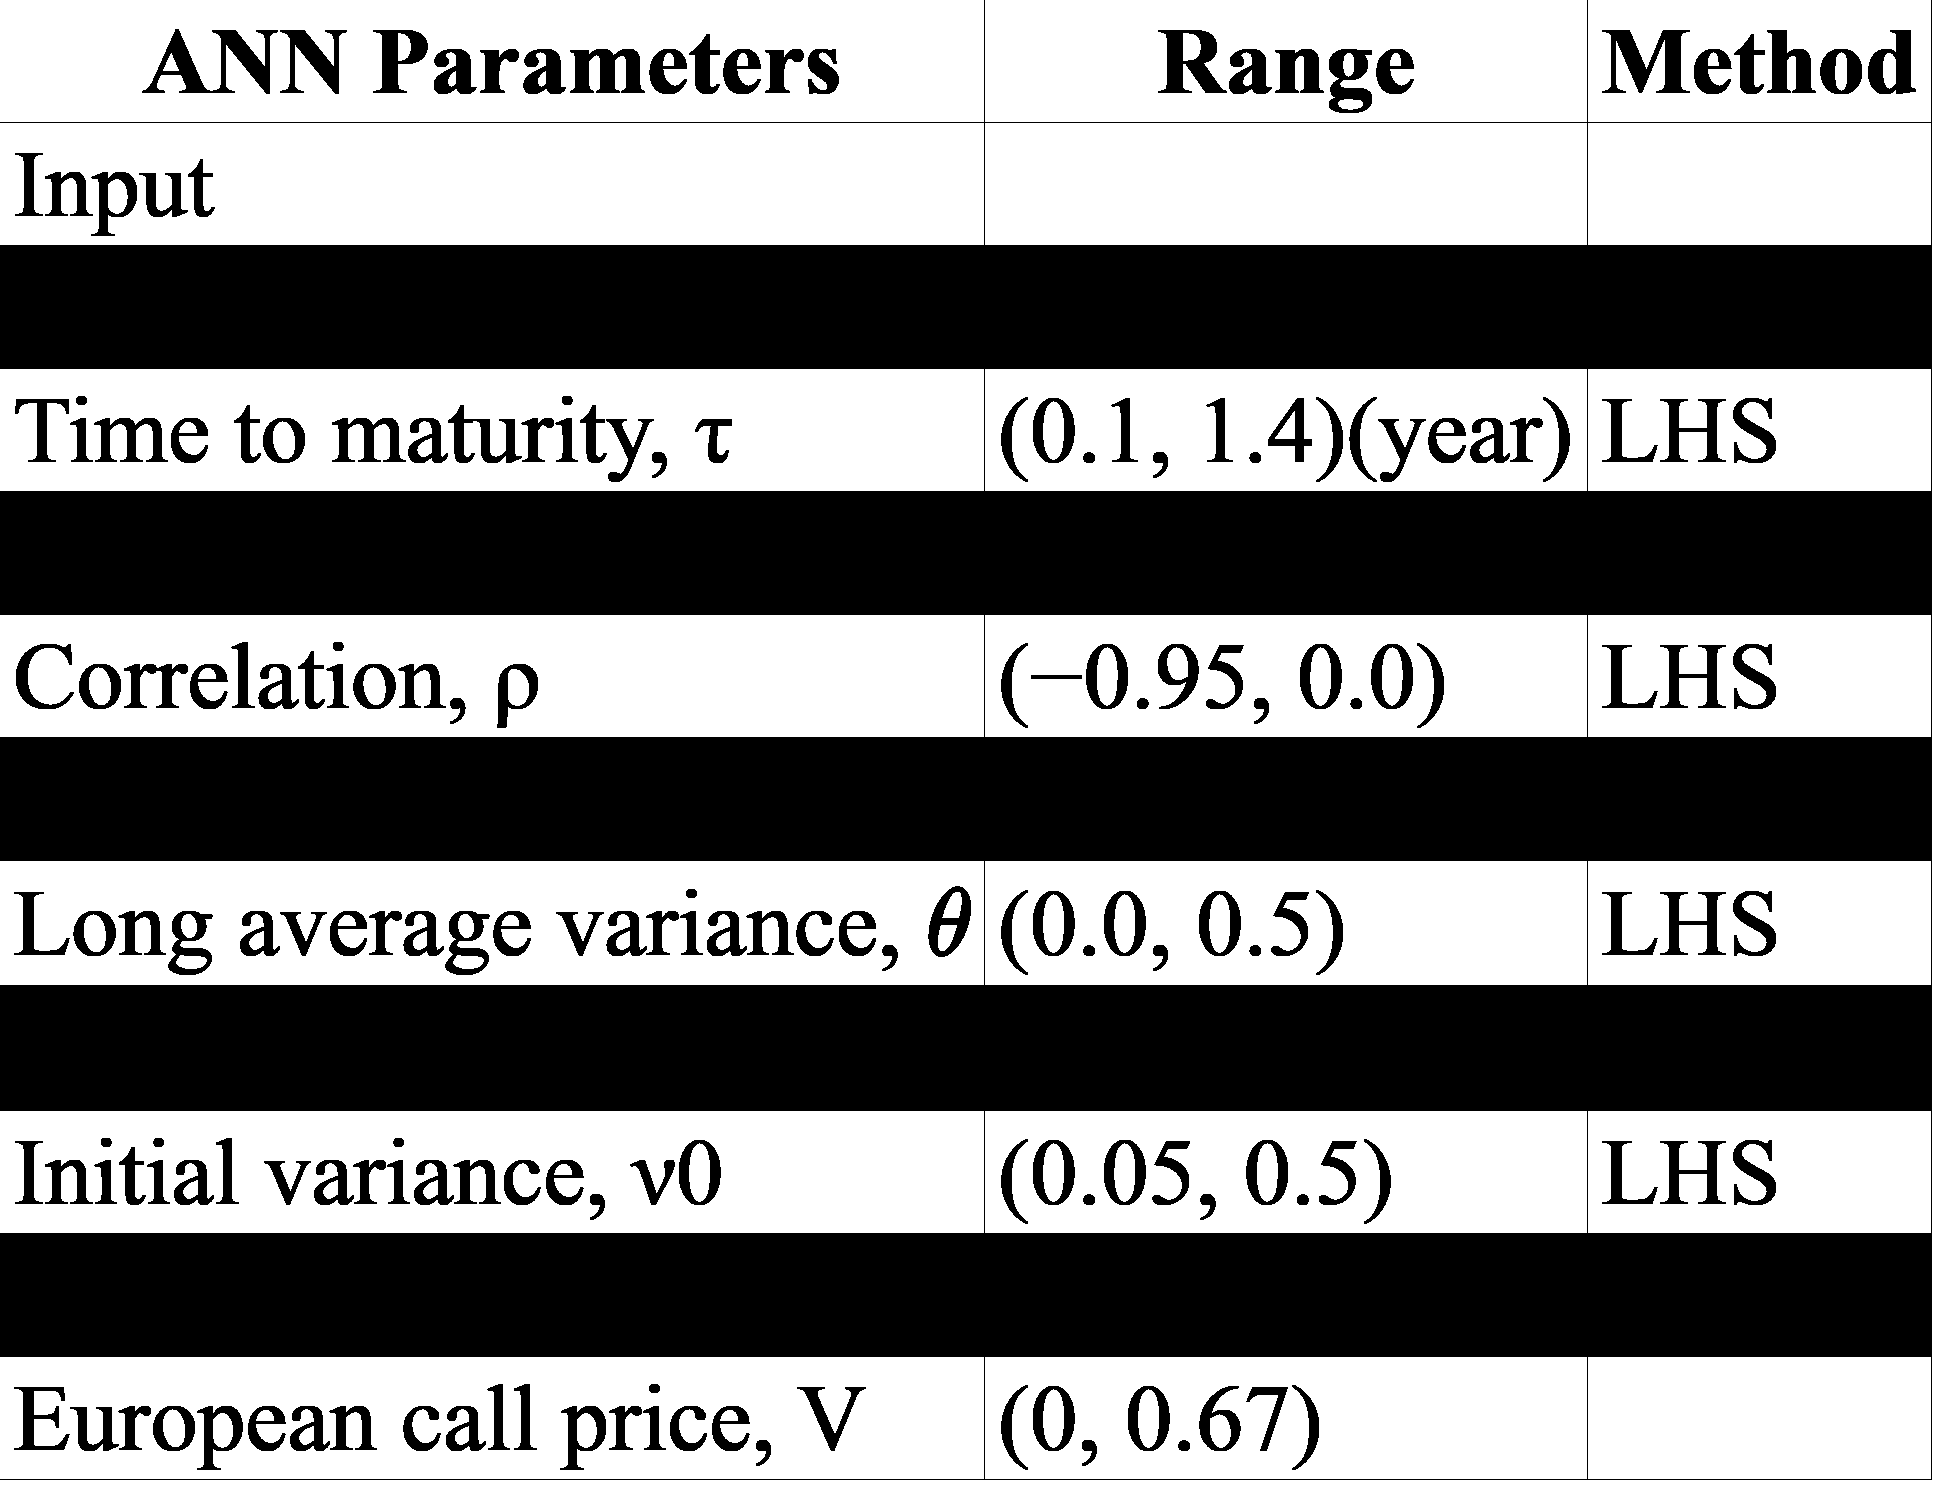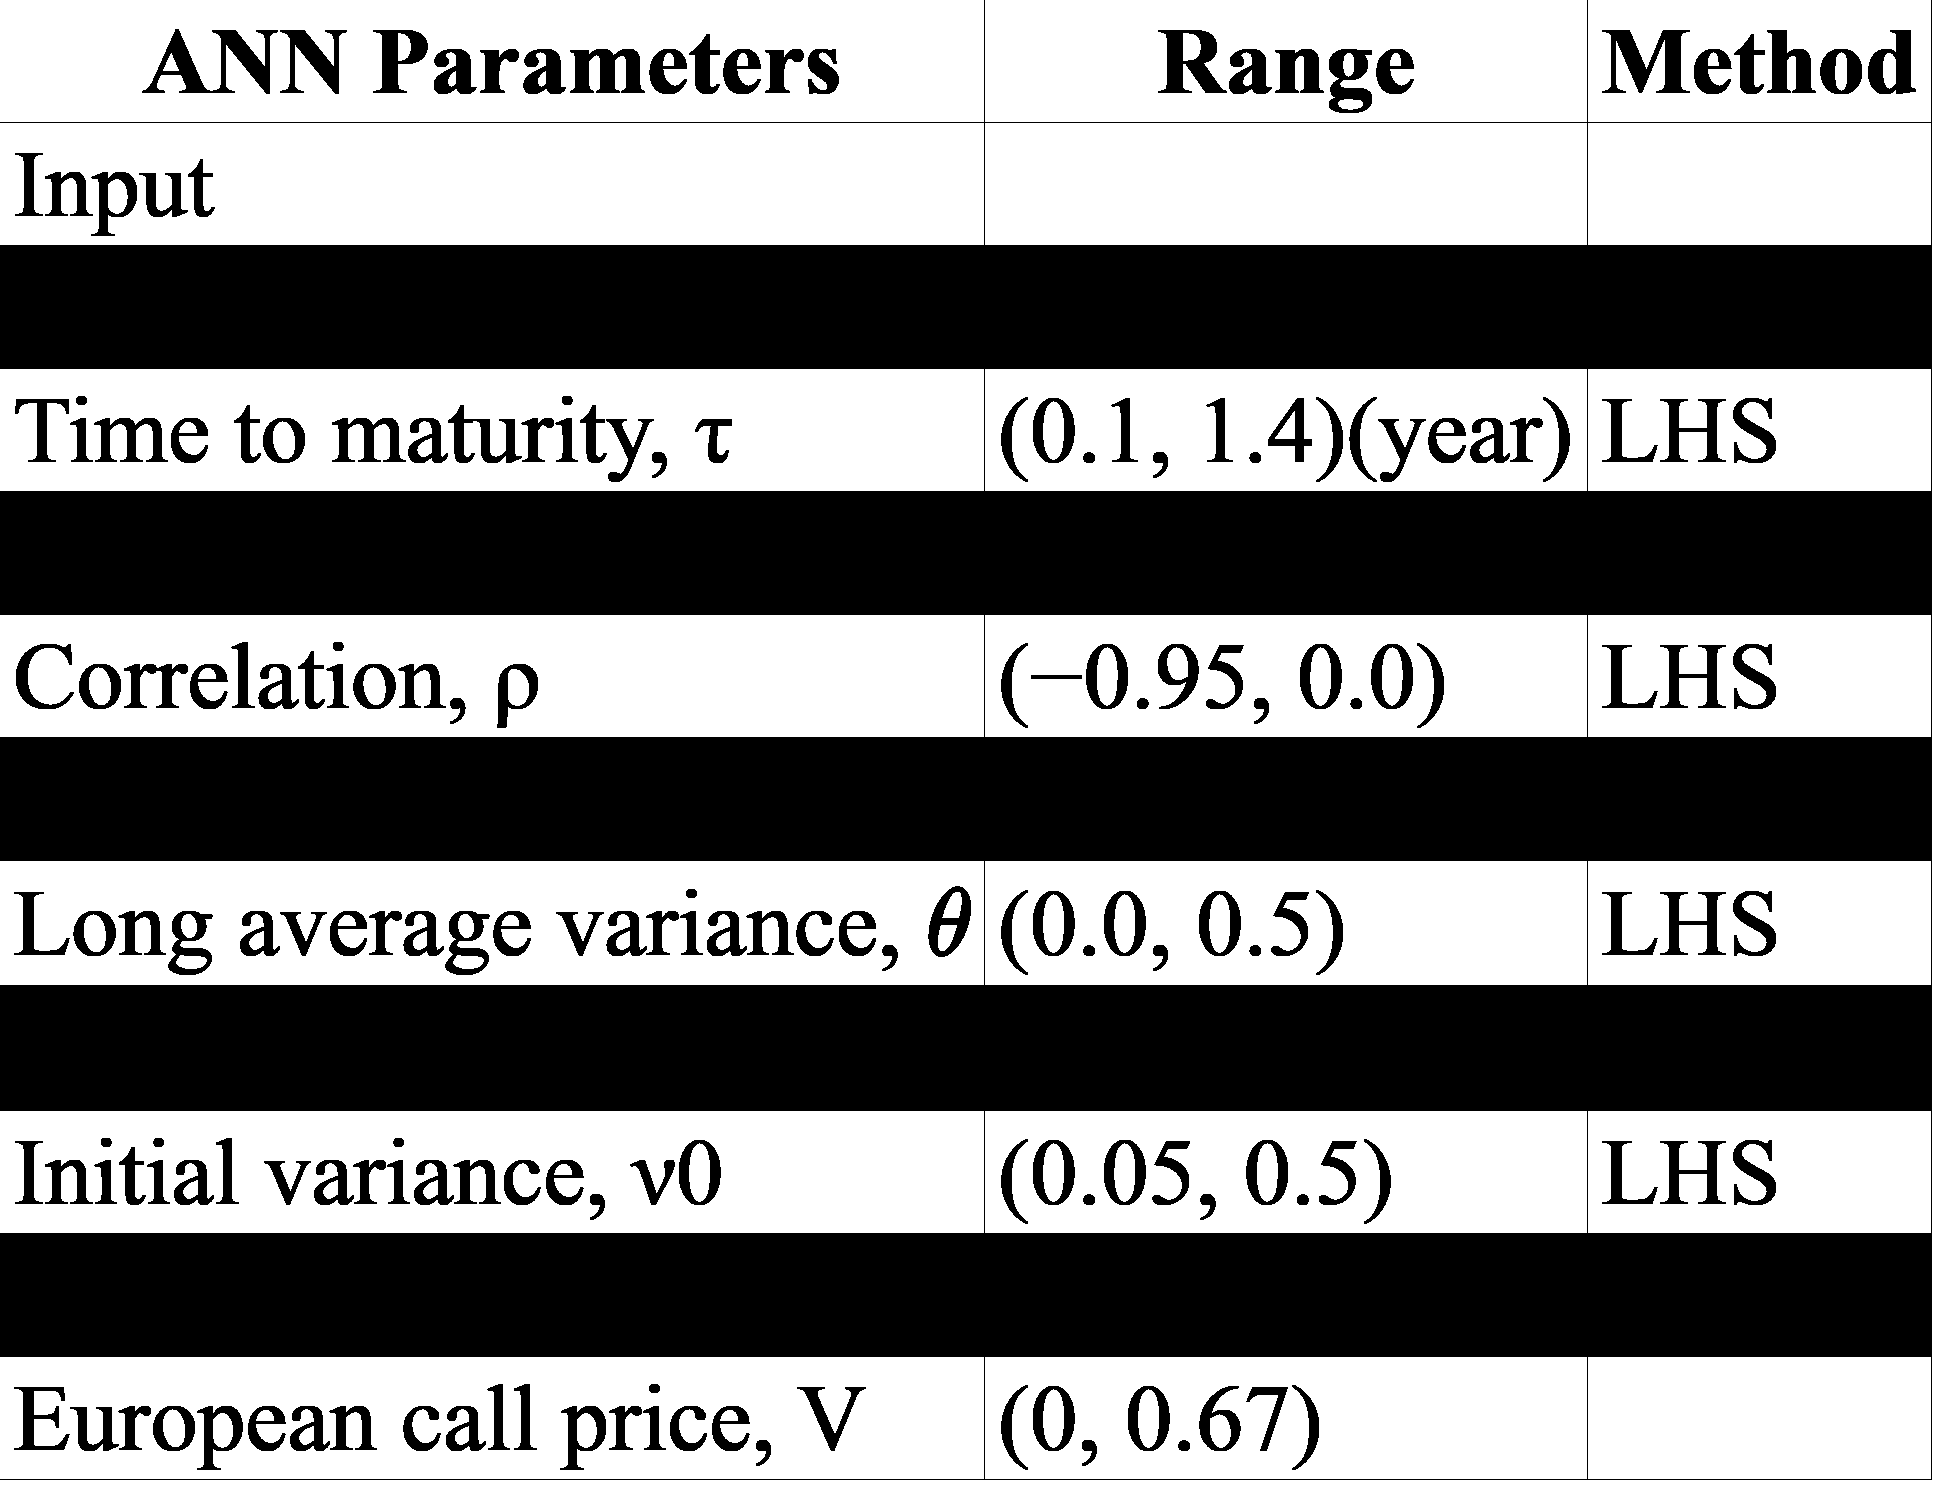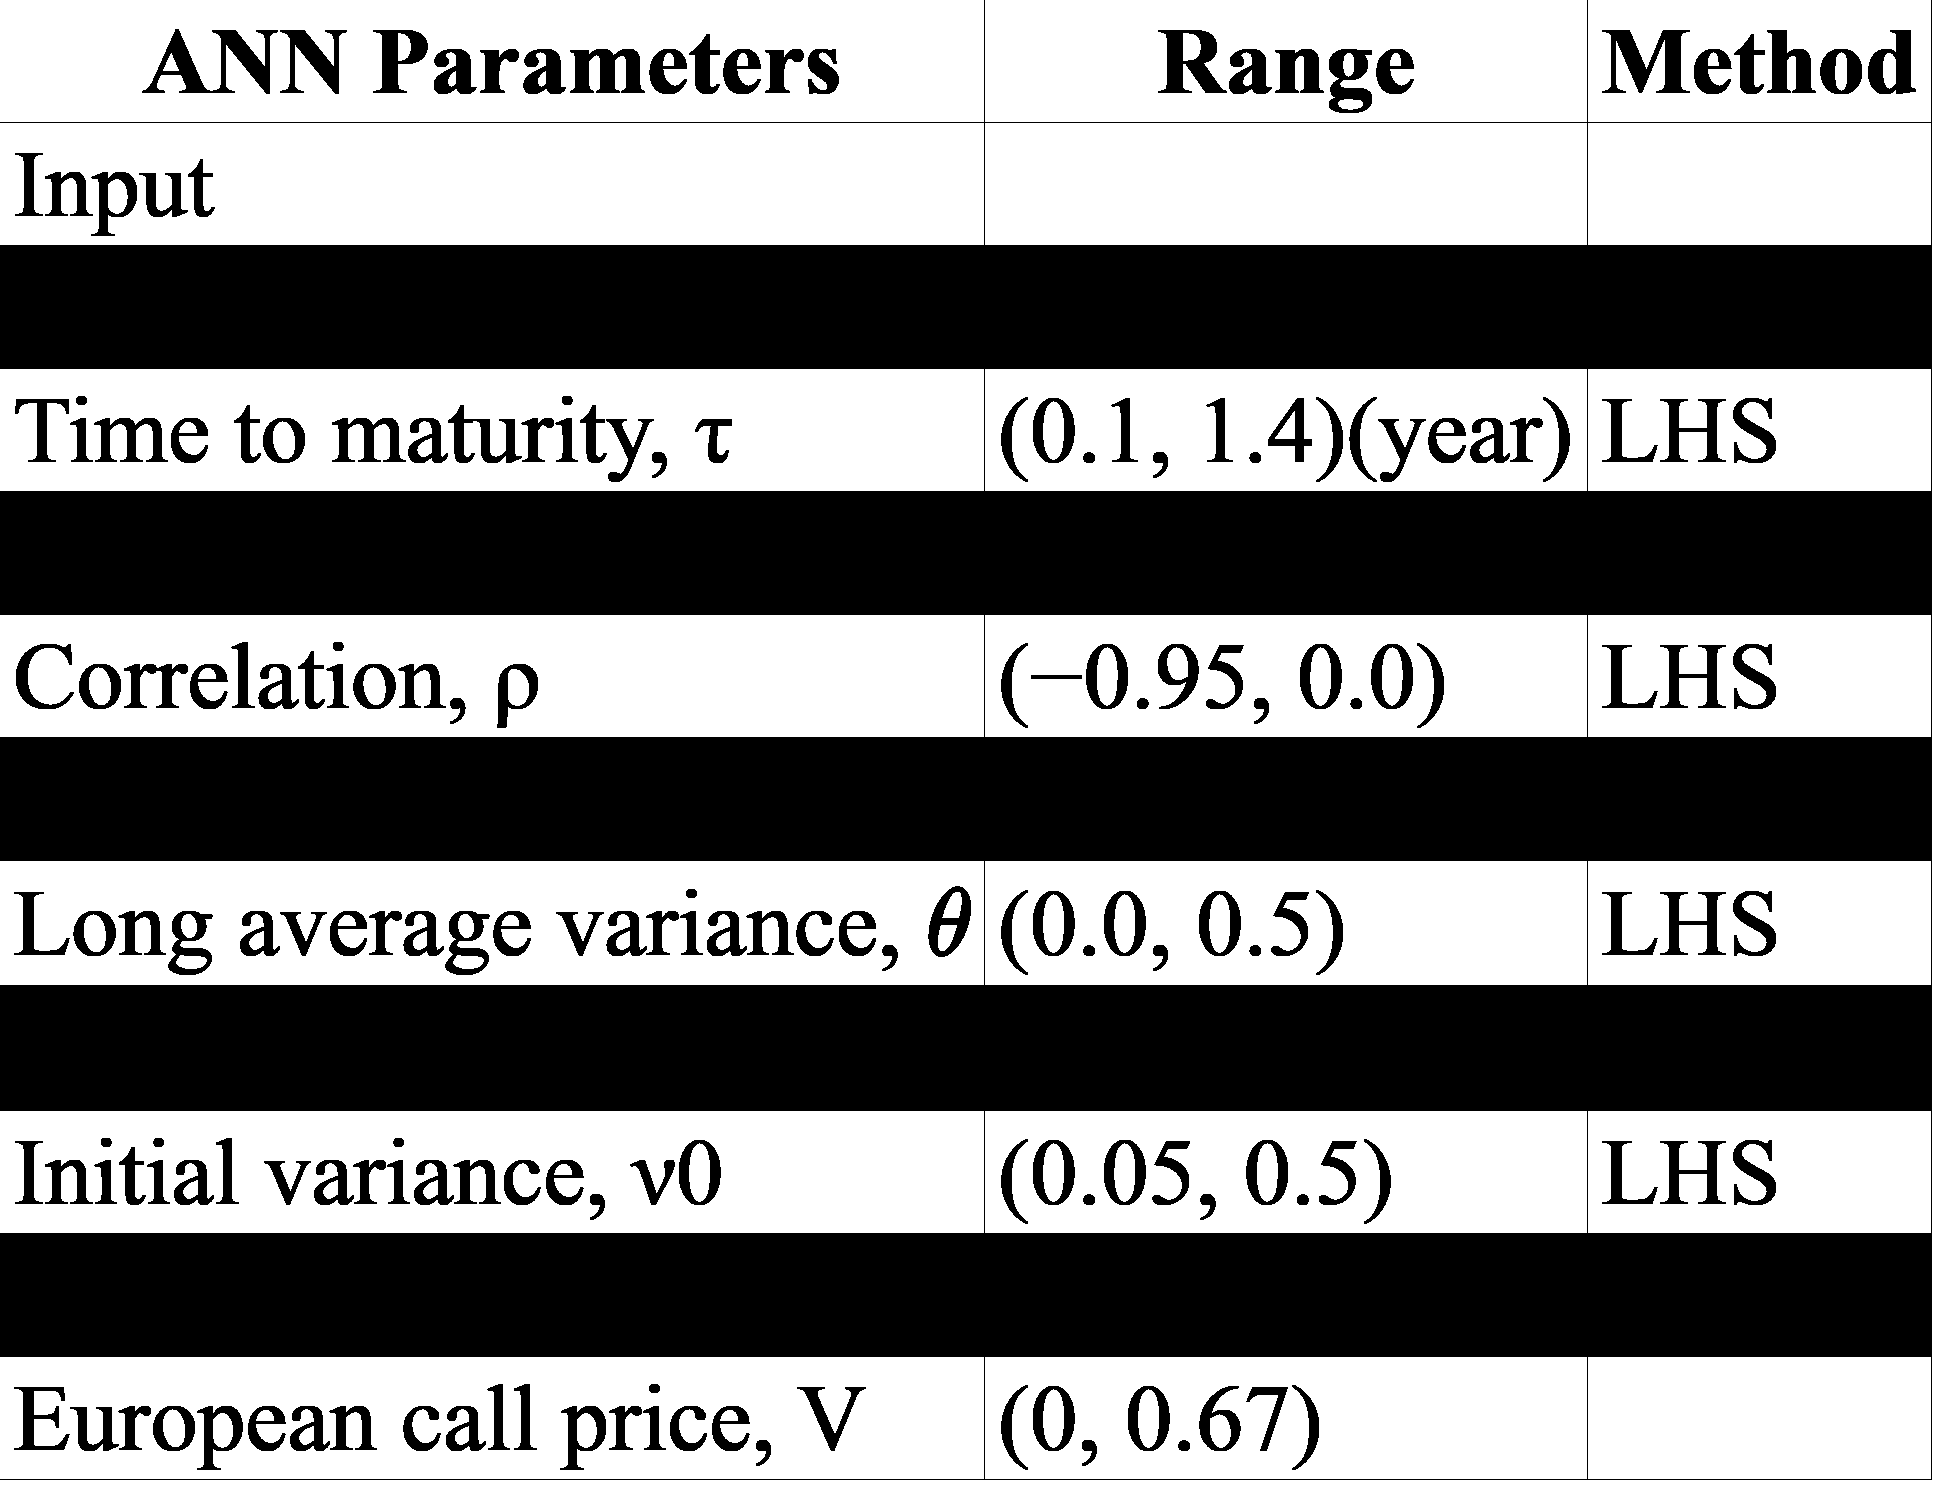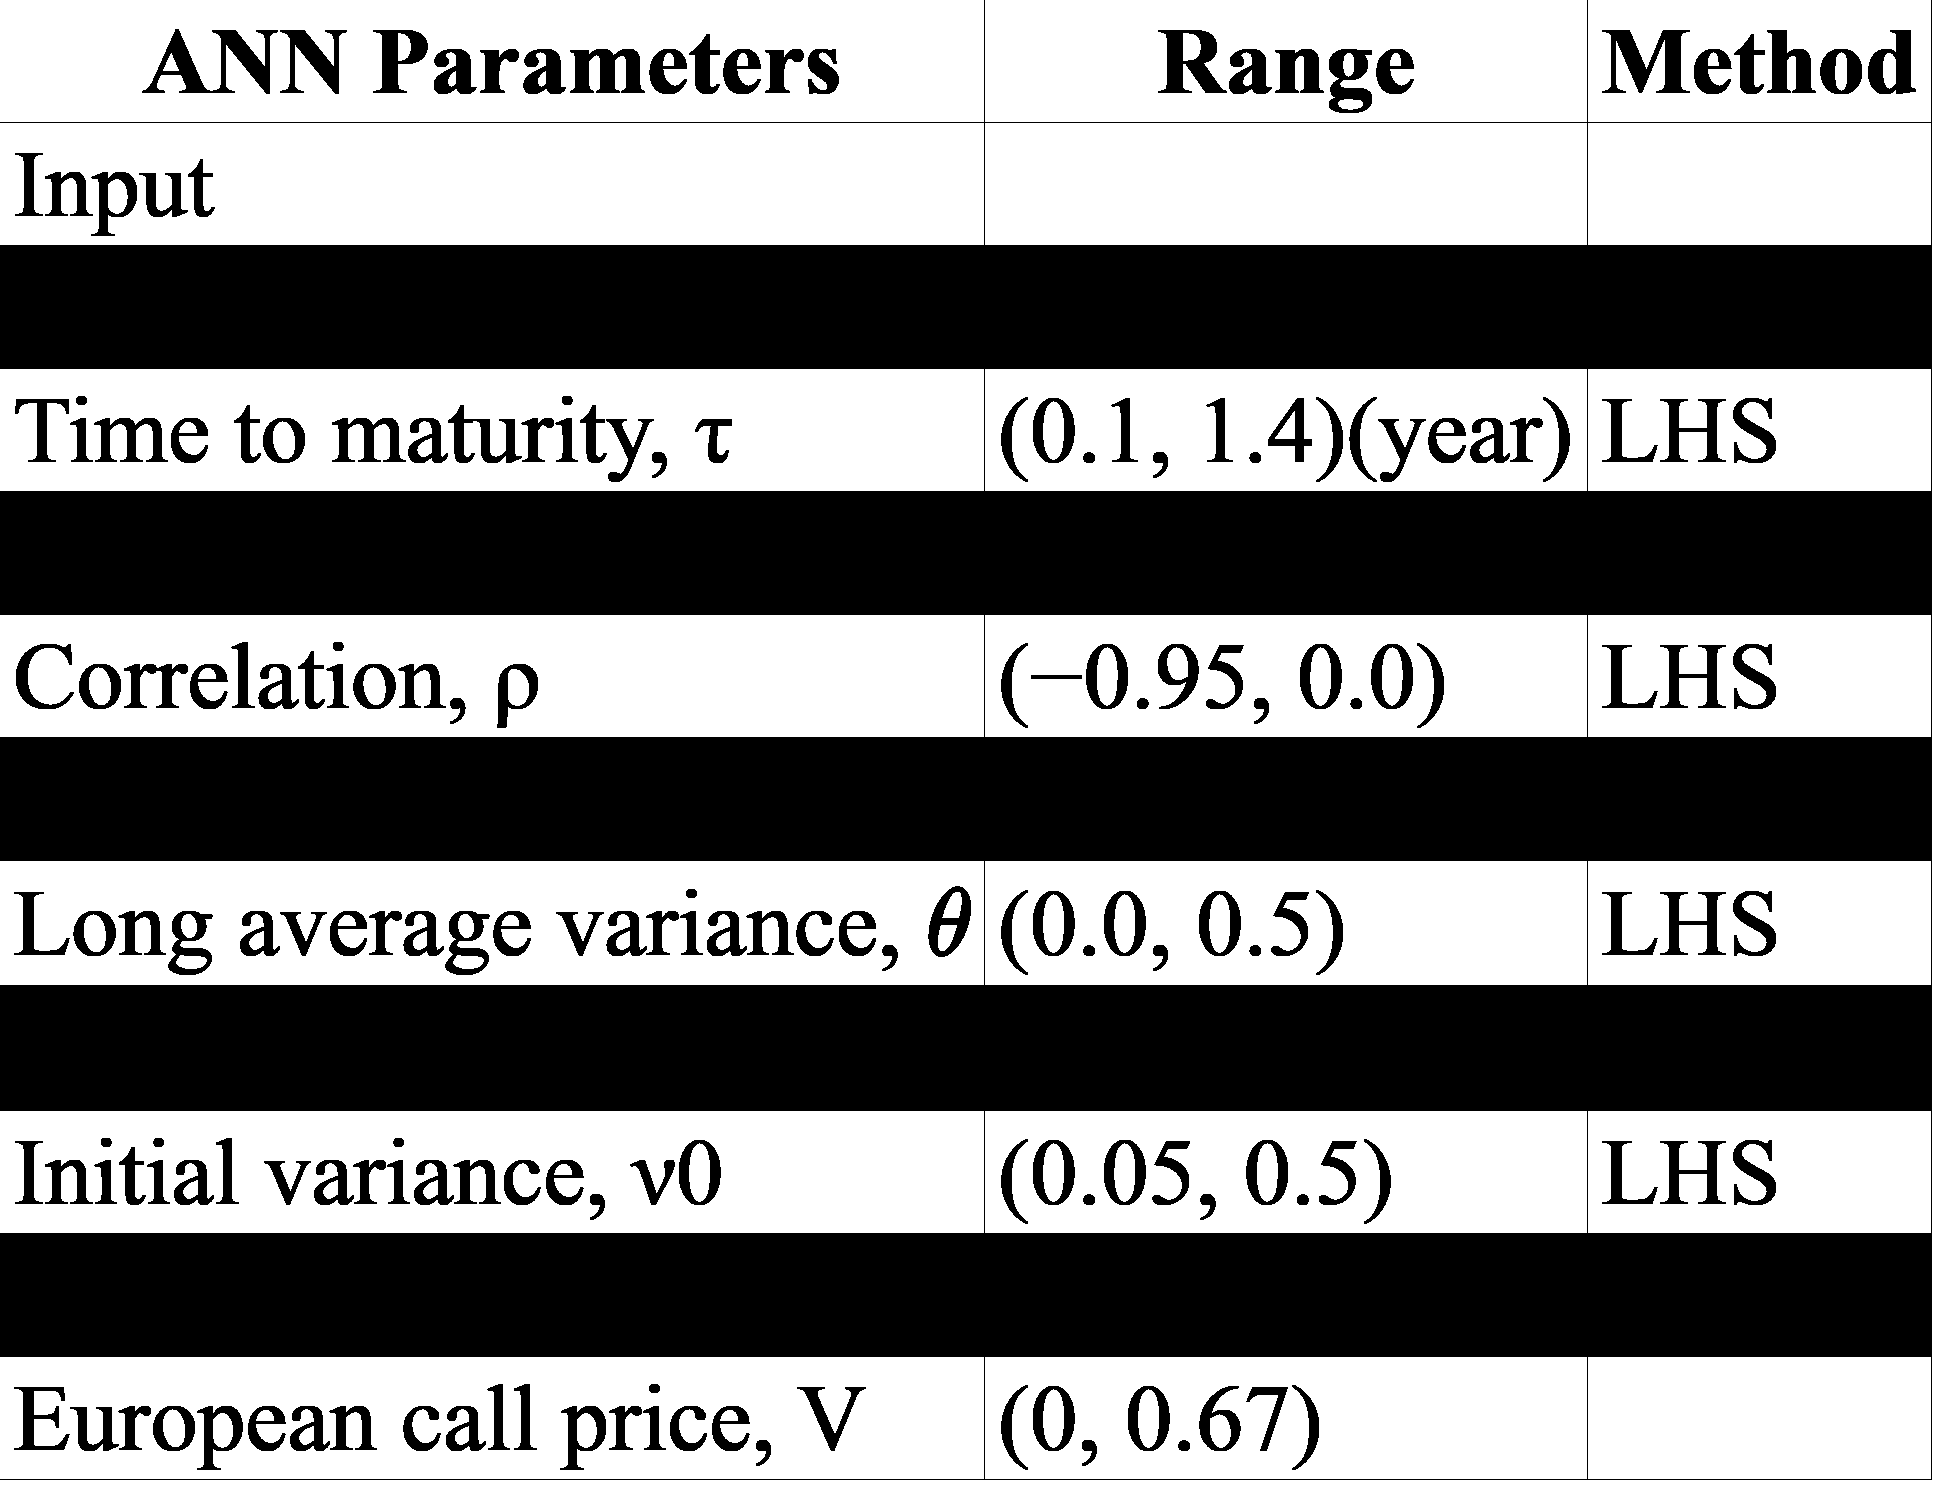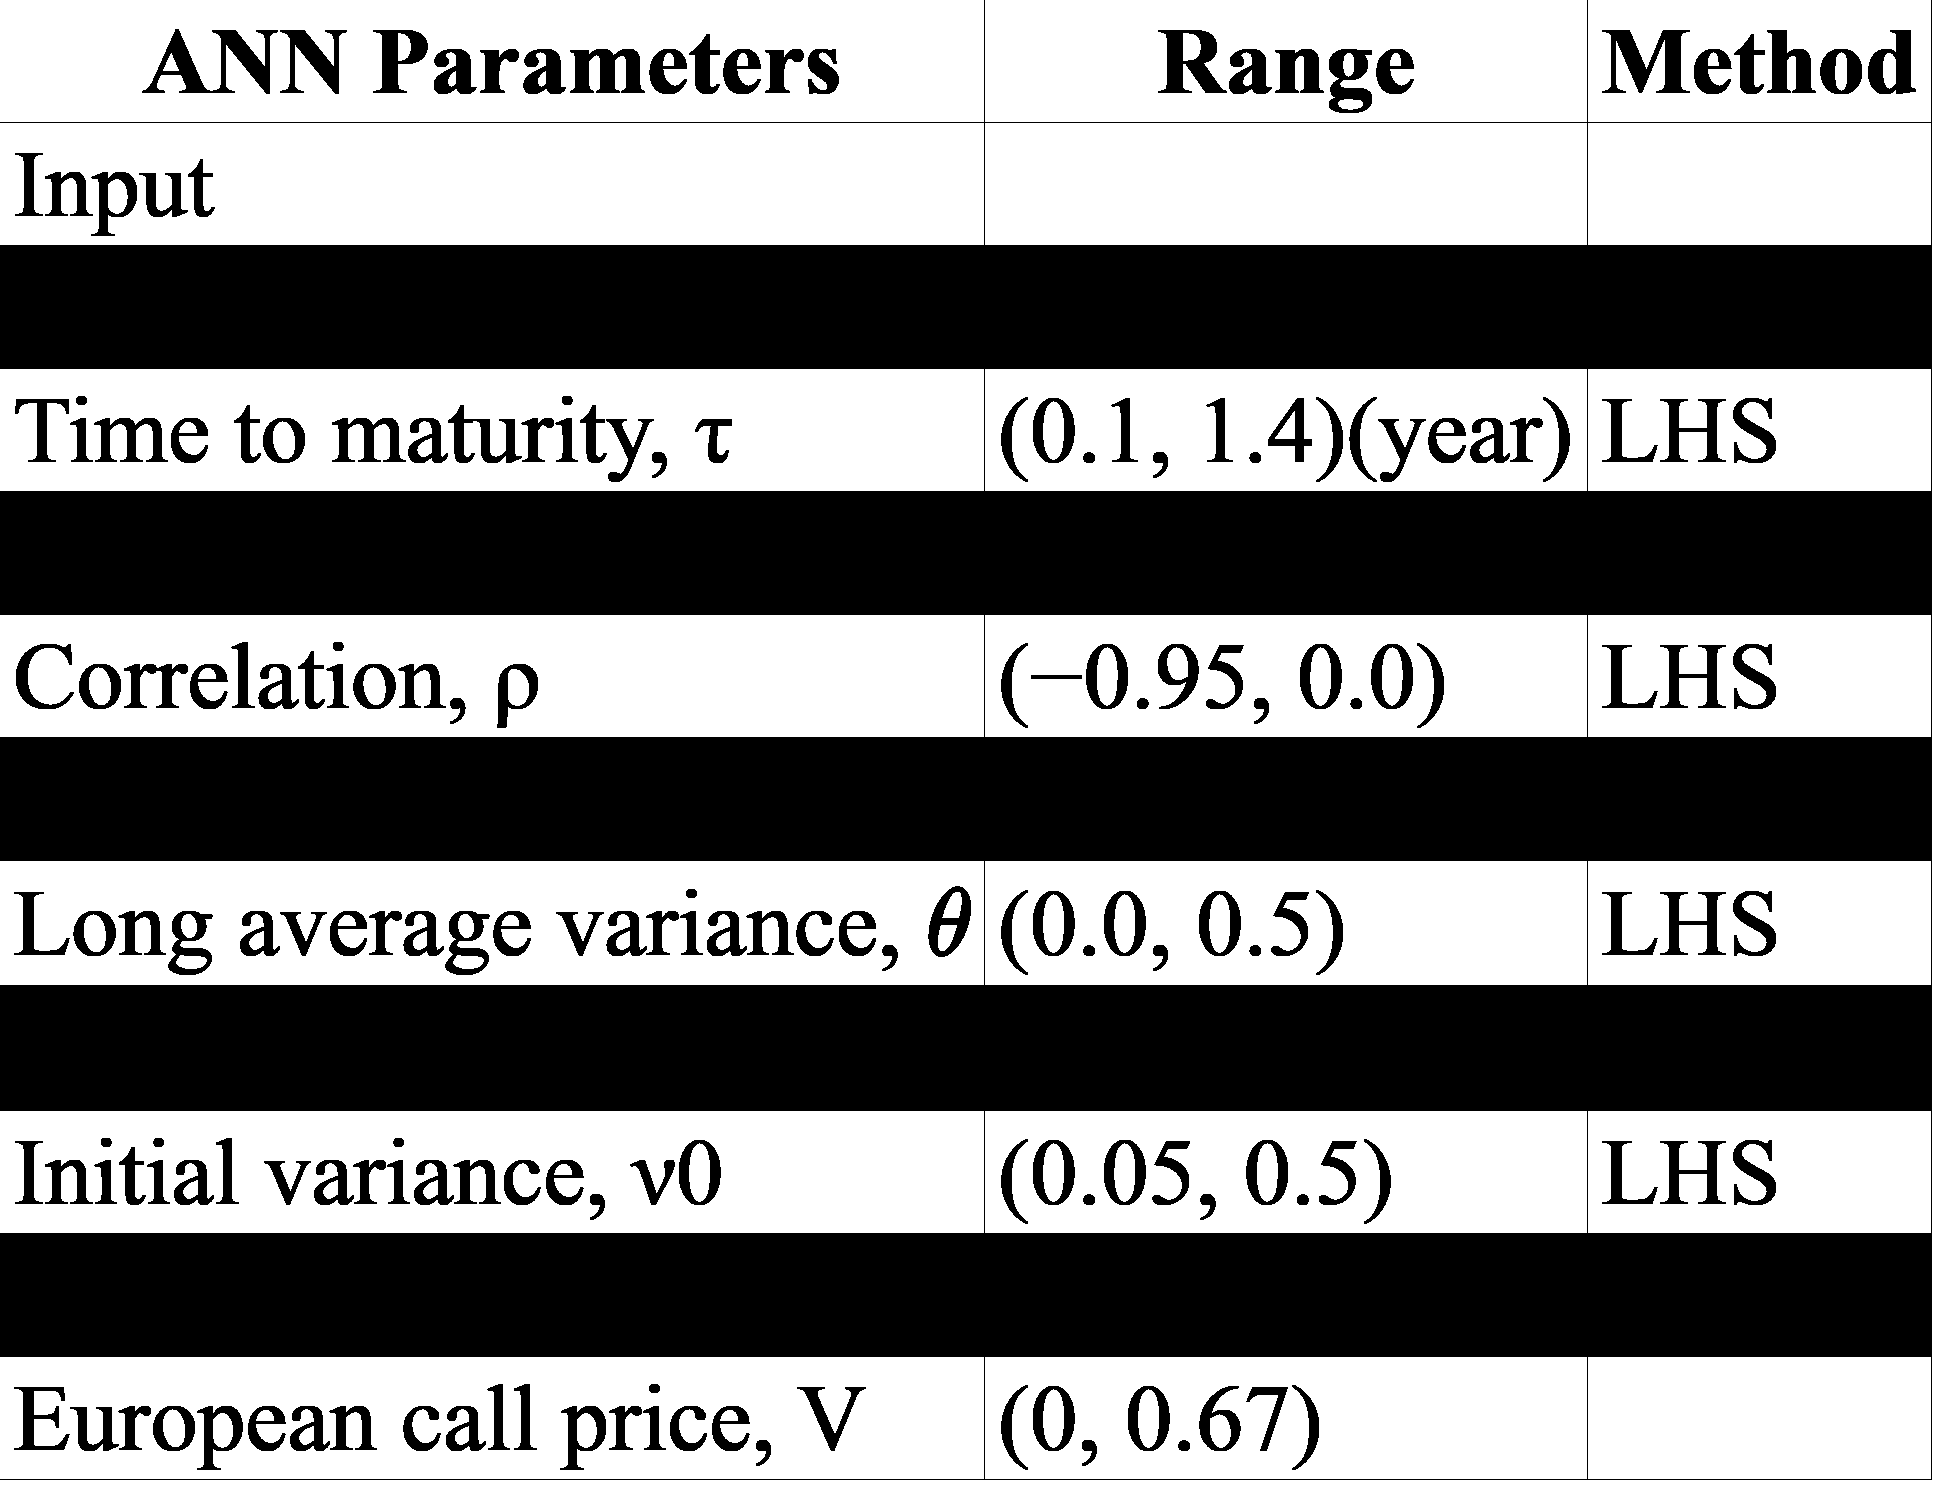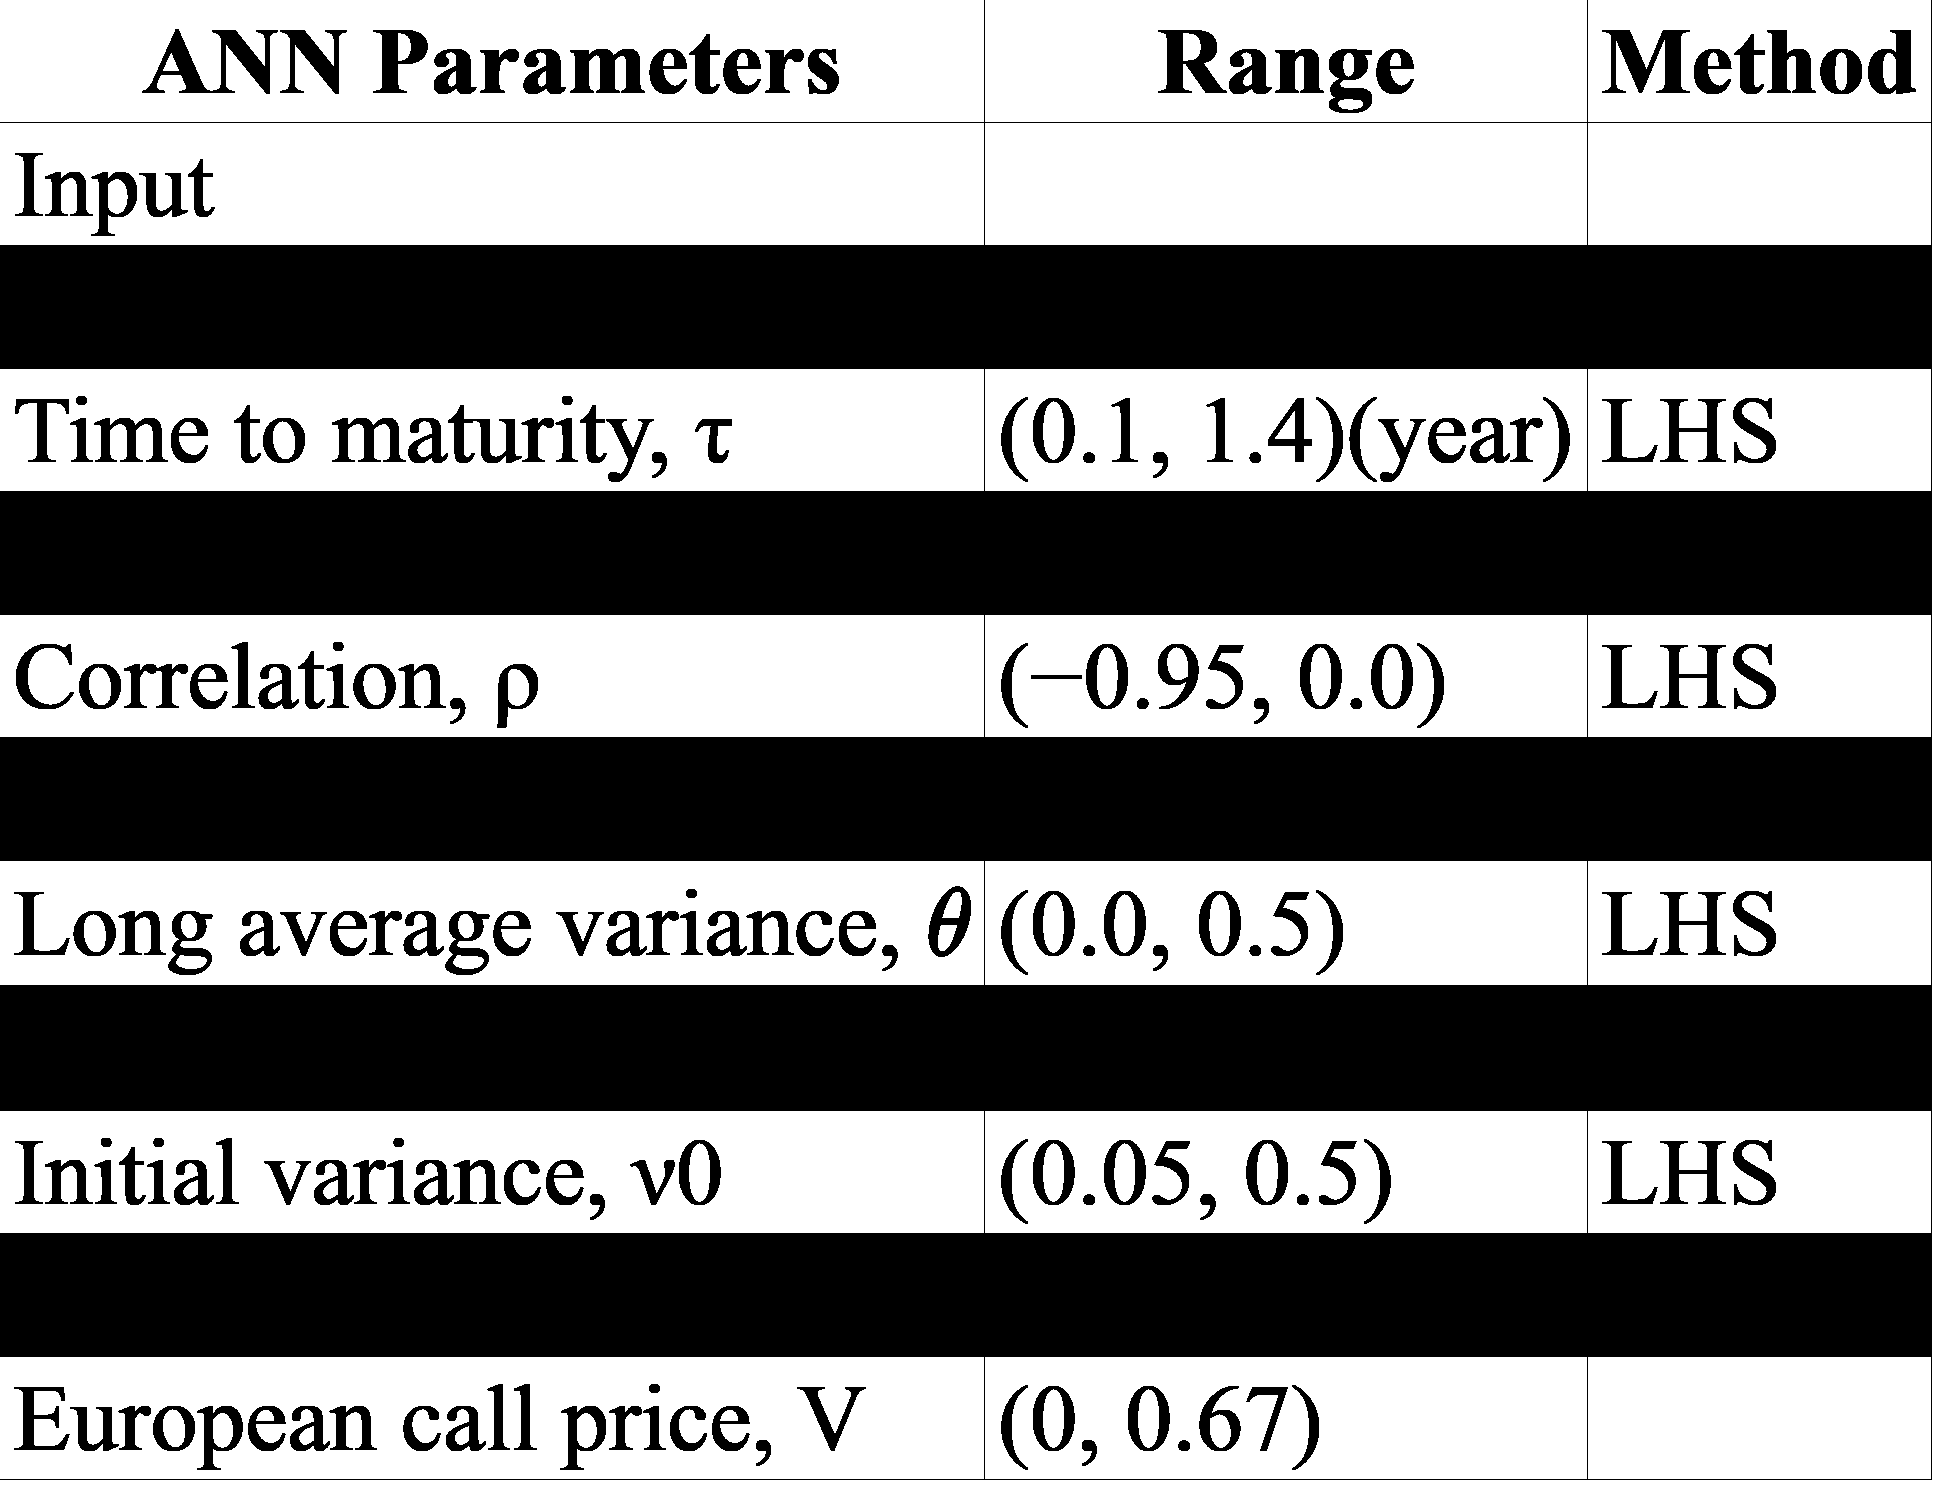)

In [ ]:
def heston_price(m, v0, kappa, theta, sigma, rho, tau, r, a, b, N_cos):

    sum=0
    sum1=0

    moneyness = m - r* tau
    for k in range(0, N_cos):
      args = (m, v0, kappa, theta, sigma, rho, tau, r, a, b)
      res= heston_charfunc(k* np.pi/(b-a), *args)* U_k(k, a, b)* np.exp(-1j* k* np.pi* ((moneyness+ a)/(b-a)))
      if k==0 :
        sum1=res
      else:
        sum+=res

    result= np.exp(-r* tau)* np.real(0.5* sum1+ sum)

    return result

def heston_price(m, v0, kappa, theta, sigma, rho, tau, r, a, b, N_cos):

    sum=0
    sum1=0

    moneyness = m - r* tau
    for k in range(0, N_cos):
      args = (m, v0, kappa, theta, sigma, rho, tau, r, a, b)
      res= heston_charfunc(k* np.pi/(b-a), *args)* U_k_calc(k, a, b)* np.exp(-1j* k* np.pi* ((moneyness+ a)/(b-a)))
      if k==0 :
        sum1=res
      else:
        sum+=res


    result= np.exp(-r* tau)* np.real(0.5* sum1+ sum)


    return result

def heston_charfunc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    args = (w, m, v0, kappa, theta, sigma, rho, tau, r, a, b)
    D= D_calc(*args)
    G= G_calc(*args)
    result= np.exp(1j* w* r* tau+ (v0/(sigma**2))* ((1- np.exp(-1* D* tau))/(1-G* np.exp(-1* D* tau)))
    * (kappa- (1j* rho* sigma* w)- D))* np.exp((kappa* theta/ (sigma**2))* (tau* (kappa- 1j* rho* sigma* w- D)-
                                                                                   2* np.log((1- G* np.exp(-1* D* tau))/(1-G))))

    return result

def D_calc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    result= np.sqrt((kappa- 1j* rho* sigma* w)**2 + (w**2+ 1j* w)* (sigma**2))

    return result

def G_calc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    args = (w, m, v0, kappa, theta, sigma, rho, tau, r, a, b)
    D= D_calc(*args)
    result= (kappa- 1j* rho* sigma* w- D )/ (kappa- 1j* rho* sigma* w+ D)

    return result

def U_k_calc(k, a, b):

    result= (2/(b-a))* (Chi_k(k, 0, b, a, b)- Psi_k(k, 0, b, a, b))

    return result

def Chi_k(k, c, d, a, b):

    result= (1/((1+ (k* np.pi/ (b-a))**2) ))* ((np.cos(k* np.pi * ((d-a)/(b-a)))* np.exp(d))- (np.cos(k* np.pi* ((c-a)/(b-a)))* np.exp(c))
    + ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((d-a)/(b-a)))* np.exp(d))- ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((c-a)/(b-a)))* np.exp(c) ))

    return result

def Psi_k(k, c, d, a, b):

    if k==0:
      result= d-c
    else:
      result=(np.sin(k* np.pi* ((d-a)/(b-a)))- np.sin(k* np.pi* ((c-a)/(b-a))))* (b-a)/ (k* np.pi)

    # print('say_x', result)
    return result

def calc_a_b(m, v0, kappa, theta, sigma, rho, tau, r, L_cos):

    c1= r* tau+ (1- np.exp(-1* kappa* tau))* ((theta- v0)/ (2* kappa))- 0.5* theta* tau

    c2= (1/(8* (kappa**3)))* (sigma* tau* kappa* np.exp(-1* kappa* tau)*(v0-theta)* (8* kappa* rho- 4* sigma)+
                            kappa* rho* sigma* (1- np.exp(-1* kappa* tau))* (16* theta- 8* v0)+
                            2* theta* kappa* tau* (-4* kappa* rho* sigma+ sigma**2+ 4* (kappa**2))+
                            sigma**2 * ((theta- 2*v0)* np.exp(-2* kappa* tau)+ theta* (6* np.exp(-1* kappa* tau)-7)+ 2* v0)+
                            8* (kappa**2) * (v0- theta)* (1-np.exp(-1* kappa * tau)))

    a= c1- L_cos* (np.sqrt(np.abs(c2)))
    b= c1+ L_cos* (np.sqrt(np.abs(c2)))

    return a, b

# Define the LHS method with lhs function in Python library pyDOE

def lhs_sample(range_values):
    lower_bound, upper_bound = range_values
    samples = lhs(1, samples=1)  # Generating a single sample
    scaled_sample = samples * (upper_bound - lower_bound) + lower_bound
    return scaled_sample.item()

# Create an empty data frame to store the values
df = pd.DataFrame(columns=['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0', 'option_price'])


num_samples = 1000000

# Define the ranges for input parameters
dataset = []
for i in range(num_samples):
    if i % 3000 == 0:
        print(i)
    m = lhs_sample([0.6, 1.4])
    tau = lhs_sample([0.1, 1.4])
    r = lhs_sample([0.0, 0.1])
    rho = lhs_sample([-0.95, 0.0])
    kappa = lhs_sample([0.0, 2.0])
    theta = lhs_sample([0.0, 0.5])
    sigma = lhs_sample([0.0, 0.5])
    v0 = lhs_sample([0.05, 0.5])

    a, b = calc_a_b(np.log(m), v0, kappa, theta, sigma, rho, tau, r, L_cos=50)
        #print(a, b)
    option_price = heston_price(np.log(m), v0, kappa, theta, sigma, rho, tau, r, a, b, N_cos=1500)
        # dataset.append([m, tau, r, rho, kappa, theta, sigma, v0, ])
        # Append the values to the data frame
    df = df.append({
        'm': m,
        'tau': tau,
        'r': r,
        'rho': rho,
        'kappa': kappa,
        'theta': theta,
        'sigma': sigma,
        'v0': v0,
        'option_price': option_price
    }, ignore_index=True)

with open('df_{}.pickle'.format(len(df)), 'wb') as f:
  pickle.dump(df, f)

In [ ]:
# load df by pickle
with open('df_1000000.pickle', 'rb') as f:
    df = pickle.load(f)


In [ ]:
df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)

df_filtered = df[df['option_price'] < 1]
df_filtered = df_filtered[df_filtered['option_price'] >= 0]

df_filtered.head(10)


,m,tau,r,rho,kappa,theta,sigma,v0,option_price
1,1.080892,1.020494,0.002058,-0.028586,1.664885,0.106170,0.090912,0.132532,0.285182
2,0.843394,0.782183,0.043195,-0.673332,1.223706,0.069747,0.146072,0.214863,0.107293
3,0.964856,1.120729,0.019967,-0.461477,1.184829,0.023225,0.303772,0.126736,0.144862
4,0.652041,1.333551,0.096563,-0.182023,0.609228,0.048836,0.342117,0.248069,0.076505
5,0.697631,0.743730,0.003439,-0.086146,0.517560,0.331261,0.155856,0.284031,0.113898
6,1.037368,0.340311,0.096958,-0.213624,1.878998,0.447414,0.298950,0.464843,0.264390
7,0.670794,0.354778,0.004523,-0.640936,0.777355,0.135675,0.414369,0.210539,0.019302
8,0.824748,0.805505,0.014092,-0.187913,0.149101,0.493443,0.386122,0.139422,0.536840
9,0.604418,1.160100,0.070686,-0.257443,1.542541,0.037022,0.179233,0.102141,0.004618
10,1.290483,0.910288,0.033090,-0.889620,0.621965,0.162592,0.364803,0.336901,0.745236


In [ ]:
# Split the dataset into train and test sets

train_df, test_df = train_test_split(df_filtered, test_size=0.1, random_state=55)
train_df, eval_df = train_test_split(train_df, test_size=1/9, random_state=55)


In [ ]:
# Check if GPU is available

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Create a TensorFlow session and set it to use the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

GPU found


In [ ]:
def calc_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse, 'mae': mae, 'r2': r2}

<div id="Step 2: Heston Option Pricing ANN">
    <h1>Step 2: Heston Option Pricing ANN</h1>
</div>

 <h4> Parameters of the ANN </h4>

<center>

| Parameters        | Options            |
|-------------------|--------------------|
| Hidden layers     | 4                  |
| Neurons(each layer)| 400                |
| Activation        | ReLU               |
| Dropout rate      | 0.0                |
| Batch-normalization| No                 |
| Initialization    | Glorot_uniform     |
| Optimizer         | Adam               |
| Batch size        | 1024               |

</center>

In [ ]:
model = Sequential()
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(8,)))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(400, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model on the GPU

batch_size = 1024
epochs = 100
with tf.device('/GPU:0'):
    history = model.fit(
        x = train_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0']],
        y = train_df['option_price'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

Epoch 1/100
719/719 [==============================] - 10s 4ms/step - loss: 0.0033
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0015
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0014
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0013
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0012
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0012
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 8/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 9/100
719/719 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 10/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 11/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 12/100
719/719 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 13/100

In [ ]:
# Evaluate the trained model on the test sets on the GPU

with tf.device('/GPU:0'):
    wide_test_loss = model.evaluate(
        test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0']],
        test_df['option_price'],
        verbose=0
    )

wide_test_predictions = model.predict(test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0']])


# Reshape wide_test_predictions to match the shape of test_df['option_price']
wide_test_predictions = wide_test_predictions.flatten()

# Calculate performance metrics for wide test set
res = calc_metrics(test_df['option_price'], wide_test_predictions)
print(res)

2874/2874 [==============================] - 5s 2ms/step
{'mse': 0.001004394715258821, 'mae': 0.009025426892304482, 'r2': 0.9800865105589234}


<div id="Step 3: Heston Implicit Volatility ANN">
    <h1>Step 3: Heston Implicit Volatility ANN</h1>
</div>

Epoch 1/200
716/719 [============================>.] - ETA: 0s - loss: 0.0726
Epoch 1: val_loss improved from inf to 0.03251, saving model to best_model


719/719 [==============================] - 12s 11ms/step - loss: 0.0724 - val_loss: 0.0325
Epoch 2/200
718/719 [============================>.] - ETA: 0s - loss: 0.0159
Epoch 2: val_loss did not improve from 0.03251
719/719 [==============================] - 6s 9ms/step - loss: 0.0159 - val_loss: 0.0362
Epoch 3/200
719/719 [==============================] - ETA: 0s - loss: 0.0147
Epoch 3: val_loss did not improve from 0.03251
719/719 [==============================] - 5s 7ms/step - loss: 0.0147 - val_loss: 0.0520
Epoch 4/200
714/719 [============================>.] - ETA: 0s - loss: 0.0136
Epoch 4: val_loss did not improve from 0.03251
719/719 [==============================] - 6s 9ms/step - loss: 0.0136 - val_loss: 0.0373
Epoch 5/200
715/719 [============================>.] - ETA: 0s - loss: 0.0125
Epoch 5: val_loss improved from 0.03251 to 0.02023, saving model to best_model


719/719 [==============================] - 8s 10ms/step - loss: 0.0125 - val_loss: 0.0202
Epoch 6/200
719/719 [==============================] - ETA: 0s - loss: 0.0110
Epoch 6: val_loss improved from 0.02023 to 0.01014, saving model to best_model


719/719 [==============================] - 9s 12ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 7/200
718/719 [============================>.] - ETA: 0s - loss: 0.0115
Epoch 7: val_loss did not improve from 0.01014
719/719 [==============================] - 5s 7ms/step - loss: 0.0115 - val_loss: 0.0186
Epoch 8/200
714/719 [============================>.] - ETA: 0s - loss: 0.0126
Epoch 8: val_loss did not improve from 0.01014
719/719 [==============================] - 7s 9ms/step - loss: 0.0126 - val_loss: 0.0397
Epoch 9/200
715/719 [============================>.] - ETA: 0s - loss: 0.0130
Epoch 9: val_loss did not improve from 0.01014
719/719 [==============================] - 5s 7ms/step - loss: 0.0130 - val_loss: 0.0346
Epoch 10/200
718/719 [============================>.] - ETA: 0s - loss: 0.0123
Epoch 10: val_loss did not improve from 0.01014
719/719 [==============================] - 6s 8ms/step - loss: 0.0123 - val_loss: 0.0203
Epoch 11/200
718/719 [============================>.

719/719 [==============================] - 8s 11ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 12/200
719/719 [==============================] - ETA: 0s - loss: 0.0102
Epoch 12: val_loss did not improve from 0.00940
719/719 [==============================] - 6s 9ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 13/200
715/719 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 13: val_loss did not improve from 0.00940
719/719 [==============================] - 6s 8ms/step - loss: 0.0108 - val_loss: 0.0157
Epoch 14/200
718/719 [============================>.] - ETA: 0s - loss: 0.0116
Epoch 14: val_loss did not improve from 0.00940
719/719 [==============================] - 6s 8ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 15/200
718/719 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 15: val_loss did not improve from 0.00940
719/719 [==============================] - 7s 10ms/step - loss: 0.0117 - val_loss: 0.0187
Epoch 16/200
713/719 [=======================

719/719 [==============================] - 50s 70ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 18/200
715/719 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 18: val_loss did not improve from 0.00741
719/719 [==============================] - 7s 9ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 19/200
716/719 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 19: val_loss did not improve from 0.00741
719/719 [==============================] - 5s 8ms/step - loss: 0.0101 - val_loss: 0.0109
Epoch 20/200
718/719 [============================>.] - ETA: 0s - loss: 0.0105
Epoch 20: val_loss did not improve from 0.00741
719/719 [==============================] - 6s 9ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 21/200
714/719 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 21: val_loss did not improve from 0.00741
719/719 [==============================] - 5s 7ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 22/200
715/719 [=======================

719/719 [==============================] - 8s 12ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 24/200
718/719 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 24: val_loss did not improve from 0.00676
719/719 [==============================] - 6s 8ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 25/200
719/719 [==============================] - ETA: 0s - loss: 0.0094
Epoch 25: val_loss did not improve from 0.00676
719/719 [==============================] - 6s 9ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 26/200
719/719 [==============================] - ETA: 0s - loss: 0.0096
Epoch 26: val_loss did not improve from 0.00676
719/719 [==============================] - 5s 7ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 27/200
719/719 [==============================] - ETA: 0s - loss: 0.0094
Epoch 27: val_loss did not improve from 0.00676
719/719 [==============================] - 6s 9ms/step - loss: 0.0094 - val_loss: 0.0103
Epoch 28/200
719/719 [========================

719/719 [==============================] - 9s 13ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 35/200
718/719 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 35: val_loss did not improve from 0.00654
719/719 [==============================] - 5s 8ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 36/200
718/719 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 36: val_loss did not improve from 0.00654
719/719 [==============================] - 6s 9ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 37/200
719/719 [==============================] - ETA: 0s - loss: 0.0087
Epoch 37: val_loss did not improve from 0.00654
719/719 [==============================] - 6s 8ms/step - loss: 0.0087 - val_loss: 0.0072
Epoch 38/200
718/719 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 38: val_loss did not improve from 0.00654
719/719 [==============================] - 5s 7ms/step - loss: 0.0087 - val_loss: 0.0069
Epoch 39/200
715/719 [========================

719/719 [==============================] - 9s 12ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 40/200
717/719 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 40: val_loss improved from 0.00654 to 0.00633, saving model to best_model


719/719 [==============================] - 9s 13ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 41/200
717/719 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 41: val_loss did not improve from 0.00633
719/719 [==============================] - 5s 7ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 42/200
718/719 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 42: val_loss did not improve from 0.00633
719/719 [==============================] - 7s 10ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 43/200
714/719 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 43: val_loss did not improve from 0.00633
719/719 [==============================] - 7s 9ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 44/200
713/719 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 44: val_loss did not improve from 0.00633
719/719 [==============================] - 5s 7ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 45/200
719/719 [=======================

719/719 [==============================] - 8s 12ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 47/200
718/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 47: val_loss did not improve from 0.00629
719/719 [==============================] - 7s 9ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 48/200
713/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 48: val_loss did not improve from 0.00629
719/719 [==============================] - 5s 7ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 49/200
715/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 49: val_loss did not improve from 0.00629
719/719 [==============================] - 7s 9ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 50/200
718/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 50: val_loss did not improve from 0.00629
719/719 [==============================] - 5s 7ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 51/200
716/719 [========================

719/719 [==============================] - 8s 11ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 54/200
716/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 54: val_loss did not improve from 0.00626
719/719 [==============================] - 6s 8ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 55/200
714/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 55: val_loss did not improve from 0.00626
719/719 [==============================] - 5s 7ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 56/200
714/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 56: val_loss did not improve from 0.00626
719/719 [==============================] - 6s 9ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 57/200
716/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 57: val_loss did not improve from 0.00626
719/719 [==============================] - 5s 7ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 58/200
716/719 [========================

719/719 [==============================] - 8s 11ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 65/200
715/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 65: val_loss did not improve from 0.00625
719/719 [==============================] - 7s 9ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 66/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 66: val_loss did not improve from 0.00625
719/719 [==============================] - 5s 7ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 67/200
717/719 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 67: val_loss did not improve from 0.00625
719/719 [==============================] - 6s 8ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 68/200
719/719 [==============================] - ETA: 0s - loss: 0.0082
Epoch 68: val_loss did not improve from 0.00625
719/719 [==============================] - 7s 9ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 69/200
719/719 [========================

719/719 [==============================] - 9s 13ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 75/200
714/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 75: val_loss did not improve from 0.00624
719/719 [==============================] - 7s 10ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 76/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 76: val_loss did not improve from 0.00624
719/719 [==============================] - 7s 10ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 77/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 77: val_loss did not improve from 0.00624
719/719 [==============================] - 6s 8ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 78/200
717/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 78: val_loss did not improve from 0.00624
719/719 [==============================] - 6s 9ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 79/200
715/719 [======================

719/719 [==============================] - 8s 11ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 92/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 92: val_loss did not improve from 0.00619
719/719 [==============================] - 6s 8ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 93/200
713/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 93: val_loss did not improve from 0.00619
719/719 [==============================] - 6s 8ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 94/200
715/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 94: val_loss did not improve from 0.00619
719/719 [==============================] - 5s 7ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 95/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 95: val_loss did not improve from 0.00619
719/719 [==============================] - 6s 9ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 96/200
714/719 [========================

719/719 [==============================] - 8s 12ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 153/200
718/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 153: val_loss did not improve from 0.00617
719/719 [==============================] - 5s 8ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 154/200
716/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 154: val_loss did not improve from 0.00617
719/719 [==============================] - 5s 7ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 155/200
719/719 [==============================] - ETA: 0s - loss: 0.0082
Epoch 155: val_loss did not improve from 0.00617
719/719 [==============================] - 6s 9ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 156/200
717/719 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 156: val_loss did not improve from 0.00617
719/719 [==============================] - 5s 7ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 157/200
719/719 [===============

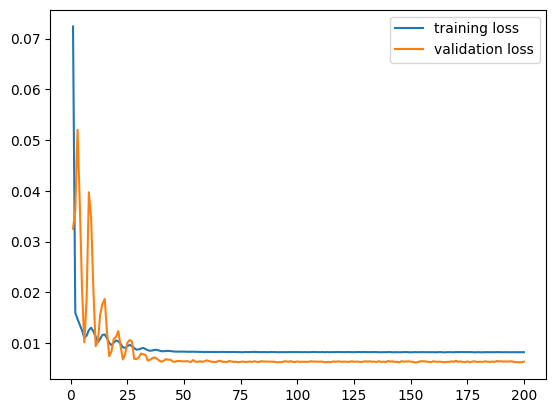

In [ ]:
model = Sequential()
model.add(Dense(600, ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(600, ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(600, ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(600, ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1, ))
epochs = 200
batch_size = 1024

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.99,
    staircase=True)

steps_per_epoch = batch_size
INIT_LR = 1e-5
MAX_LR = 1e-1

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

filepath = 'best_model'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, mode='min', monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]
callbacks=callbacks_list
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=clr), loss='mean_squared_error', )

# Train the model on the GPU

with tf.device('/GPU:0'):
    history = model.fit(
        x = train_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'v0','option_price' ]],
        y = train_df['sigma'],
        validation_data = (eval_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'v0','option_price' ]], eval_df['sigma']),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks_list
    )

# plot lines
plt.plot([i for i in range(1, len(history.history['loss'])+1)], history.history['loss'], label = "training loss")
plt.plot([i for i in range(1, len(history.history['val_loss'])+1)], history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()


In [ ]:
# Evaluate the trained model on the test sets on the GPU
# model = tf.keras.models.load_model('best_model')

with tf.device('/GPU:0'):
    wide_test_loss = model.evaluate(
        test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'v0','option_price']],
        test_df['sigma'],
        verbose=0
    )

wide_test_predictions = model.predict(test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'v0','option_price']])

# Calculate performance metrics for wide test set

res = calc_metrics(test_df['sigma'], wide_test_predictions)
print(res)

2874/2874 [==============================] - 6s 2ms/step
{'mse': 0.0064118987324165225, 'mae': 0.053238941802368274, 'r2': 0.6892325231064504}
